In [1]:
# general libraries
import pandas as pd
import pandas.testing as tm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import re
import seaborn as sns
from IPython.display import IFrame

# network analysis
import networkx as nx
from networkx.algorithms import bipartite

# text analysis
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# formatting commands
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

/Users/dpong/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

# function to get large graph components
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# function to clean string
def clean_string(text):
    '''Take any text and return a cleaned version of the text
        without punctuation, lower cased, and removes stopwords'''
    text = ''.join([w for w in text if w not in string.punctuation])
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    
    return text

# function to get the ngrams of a word or phrase
def ngrams(string, n=2):
    '''Takes any string removes characters, and creates
        ngrams of length n. Returns string and ngrams of
        string'''
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# function to get the top n cosine similarity scores
def cos_sim_top(A, B, ntop, lower_bound=0):
    '''Takes any matrix A and B and returns the top n
        matching values with the higest cosine similarity
        score'''
    
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))

# function to return the names that were run through the cossim_top function
def get_matches_df(sparse_matrix, name_vector, top=None):
    '''Takes any sparse matrix constructed from a name vector
        and returns the names and scores of values in the sparse
        matrix with a defned % cut off'''
    
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similairity})

In [3]:
# loading listing data

listing_df = pd.read_csv('listings_sydney.csv',dtype=object)
listing_df.rename(columns={'id':'listing_id'},inplace=True)
listing_df.shape

(32679, 74)

In [4]:
listing_df.head()

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,20210410042103,2021-04-12,An Oasis in the City,Very central to the city which can be reached ...,"It is very close to everything and everywhere,...",https://a0.muscache.com/pictures/2797669/17895...,40855,https://www.airbnb.com/users/show/40855,...,10,10,10,NaN,f,1,0,1,0,1.42
1,12351,https://www.airbnb.com/rooms/12351,20210410042103,2021-04-15,Sydney City & Harbour at the door,Come stay with Vinh & Stuart (Awarded as one o...,"Pyrmont is an inner-city village of Sydney, on...",https://a0.muscache.com/pictures/763ad5c8-c951...,17061,https://www.airbnb.com/users/show/17061,...,10,10,10,NaN,f,2,0,2,0,4.03
2,14250,https://www.airbnb.com/rooms/14250,20210410042103,2021-04-14,Manly Harbour House,"Beautifully renovated, spacious and quiet, our...",Balgowlah Heights is one of the most prestigio...,https://a0.muscache.com/pictures/56935671/fdb8...,55948,https://www.airbnb.com/users/show/55948,...,8,9,8,NaN,f,2,2,0,0,0.03
3,15253,https://www.airbnb.com/rooms/15253,20210410042103,2021-04-12,Unique Designer Rooftop Apartment in City Loca...,Penthouse living at it best ... You will be st...,The location is really central and there is nu...,https://a0.muscache.com/pictures/46dcb8a1-5d5b...,59850,https://www.airbnb.com/users/show/59850,...,10,10,9,NaN,t,1,0,1,0,3.30
4,44545,https://www.airbnb.com/rooms/44545,20210410042103,2021-04-13,Sunny Darlinghurst Warehouse Apartment,Sunny warehouse/loft apartment in the heart of...,Darlinghurst is home to some of Sydney's best ...,https://a0.muscache.com/pictures/a88d8e14-4f63...,112237,https://www.airbnb.com/users/show/112237,...,10,10,10,NaN,f,1,1,0,0,0.60


In [6]:
# loading reviews data

reviews_df = pd.read_csv("reviews_sydney.csv", dtype = object)
reviews_df.shape

(479739, 6)

In [7]:
# drop null comments from review data
reviews_df.dropna(inplace=True)
reviews_df.shape

(479462, 6)

In [8]:
# drop reviews containing 'This is an automated posting'
automated = reviews_df[reviews_df.comments.str.contains('This is an automated posting')].index
reviews_df.drop(index=automated, inplace=True)
reviews_df.shape

(472548, 6)

In [9]:
# reviews_df.listing_id.sort_values(ascending = True).unique()

In [10]:
# set up dataframes to merge
df_review = reviews_df[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df_listing = listing_df[['listing_id', 'host_id', 'host_name']].copy()

# merge the dataframes
df_merged = pd.merge(df_review, df_listing, how='left', on='listing_id')
df_merged.shape

(472548, 8)

In [11]:
df_listing.shape

(32679, 3)

In [12]:
df_listing.head()

,listing_id,host_id,host_name
0,11156,40855,Colleen
1,12351,17061,Stuart
2,14250,55948,Heidi
3,15253,59850,Morag
4,44545,112237,Atari


In [13]:
df_merged[df_merged.listing_id == "11156"]

,listing_id,reviewer_id,reviewer_name,id,date,comments,host_id,host_name
0,11156,52946,Jeff,19220,2009-12-05,Colleen was friendly and very helpful regardin...,40855,Colleen
1,11156,99382,Michael,32592,2010-03-31,"Great place, centrally located, easy walk to t...",40855,Colleen
2,11156,105797,Marina,42280,2010-05-14,Colleen is very friendly and helpful. The apar...,40855,Colleen
3,11156,259213,Sigrid,140942,2010-11-17,Dear Colleen!\r\nMy friend Diemut from Germany...,40855,Colleen
4,11156,273389,Eduardo,151966,2010-12-11,"Lovely, interesting chats and very helpful giv...",40855,Colleen
...,...,...,...,...,...,...,...,...
189,11156,50209480,Melissa,605572472,2020-02-14,Colleen's place is really a green haven of pea...,40855,Colleen
190,11156,88585233,Akshay,608925104,2020-02-21,Colleen is a lovely host. Very polite.,40855,Colleen
191,11156,189365519,Céline,613832320,2020-03-02,"Je recommande ce logement, idéal si vous voyag...",40855,Colleen
192,11156,1459713,Aron,614394216,2020-03-05,I advise not staying at this listing. That bei...,40855,Colleen


In [14]:
# clean the merged dataframe
df_merged.dropna(inplace=True)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.comments = df_merged.comments.map(lambda x: x.replace('\r', ''))
df_merged.reviewer_id = df_merged.reviewer_id.astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458941 entries, 0 to 472547
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     458941 non-null  object
 1   reviewer_id    458941 non-null  int64 
 2   reviewer_name  458941 non-null  object
 3   id             458941 non-null  object
 4   date           458941 non-null  object
 5   comments       458941 non-null  object
 6   host_id        458941 non-null  object
 7   host_name      458941 non-null  object
dtypes: int64(1), object(7)
memory usage: 31.5+ MB


In [15]:
# calculate the number of reviews per hosts
host_review_counts = df_merged.groupby('host_id')[['id']].nunique().reset_index()
host_review_counts.rename(columns={'id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df_merged.groupby('reviewer_id')[['id']].nunique().reset_index()
reviewer_review_counts.rename(columns={'id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df_merged.groupby('host_id')[['listing_id']].nunique().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_counts'}, inplace=True)

# calculate number of hosts reviewed by reviewers
reviewer_host_counts = df_merged.groupby(['reviewer_id'])[['host_id']].nunique().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_counts'}, inplace=True)

In [16]:
df_merged_final = pd.merge(df_merged, host_review_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_review_counts, how='left', on='reviewer_id')
df_merged_final = pd.merge(df_merged_final, host_listing_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_host_counts, how='left', on='reviewer_id')
df_merged_final.shape

(458941, 12)

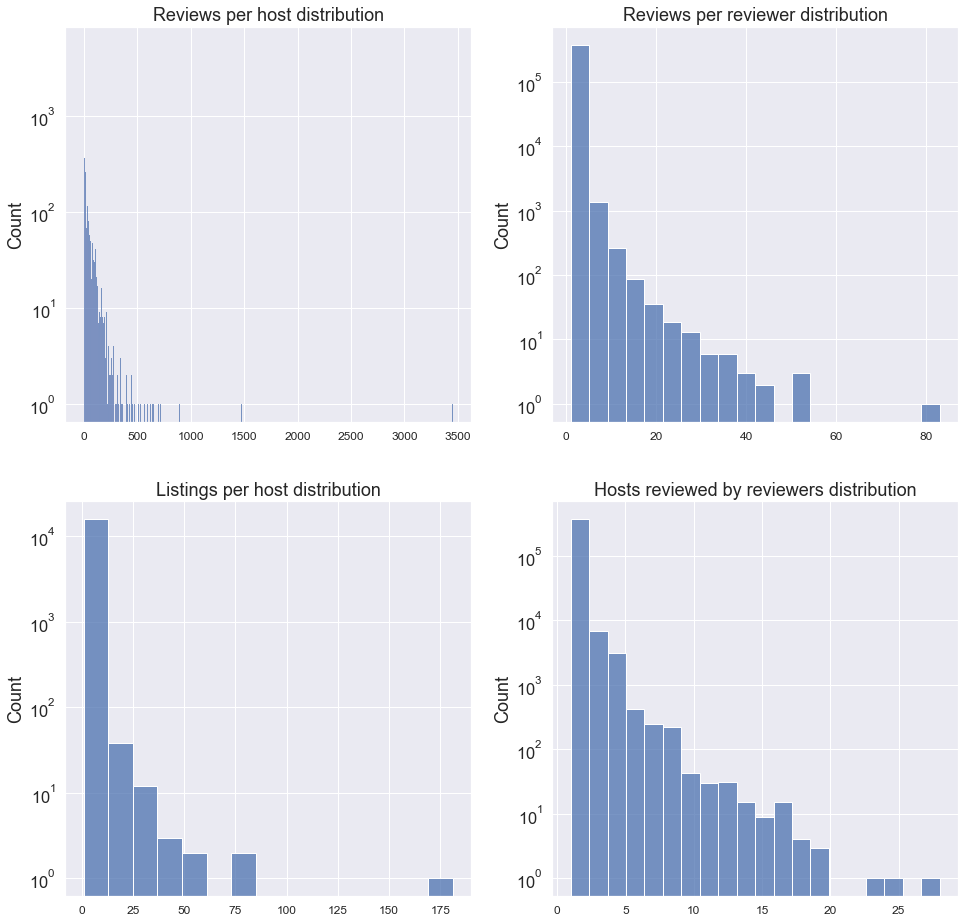

In [17]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(16, 16))
sns.histplot(host_review_counts.host_review_count, ax=ax[0,0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[0,1])
sns.histplot(host_listing_counts.host_listing_counts, ax=ax[1,0])
sns.histplot(reviewer_host_counts.reviewer_host_counts, ax=ax[1,1])
ax[0,0].set_title('Reviews per host distribution')
ax[0,1].set_title('Reviews per reviewer distribution')
ax[1,0].set_title('Listings per host distribution')
ax[1,1].set_title('Hosts reviewed by reviewers distribution')

for a in ax.flatten():
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=12, labelrotation=0)
    a.set_yscale('log')

plt.show()

In [18]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(1117, 12)

In [19]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep = False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], inplace=True)
subset.shape

(1123, 12)

In [20]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  397
Number of hosts:  133


In [21]:
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

### Initial 2-Mode Network

In [22]:
subset.reviewer_id.nunique()

397

In [23]:
subset.host_id.nunique()

133

In [24]:
G = nx.Graph()
# Use bipartite 0 or 1 to denote which node it belongs to
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [25]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 530
Number of edges: 421
Average degree:   1.5887


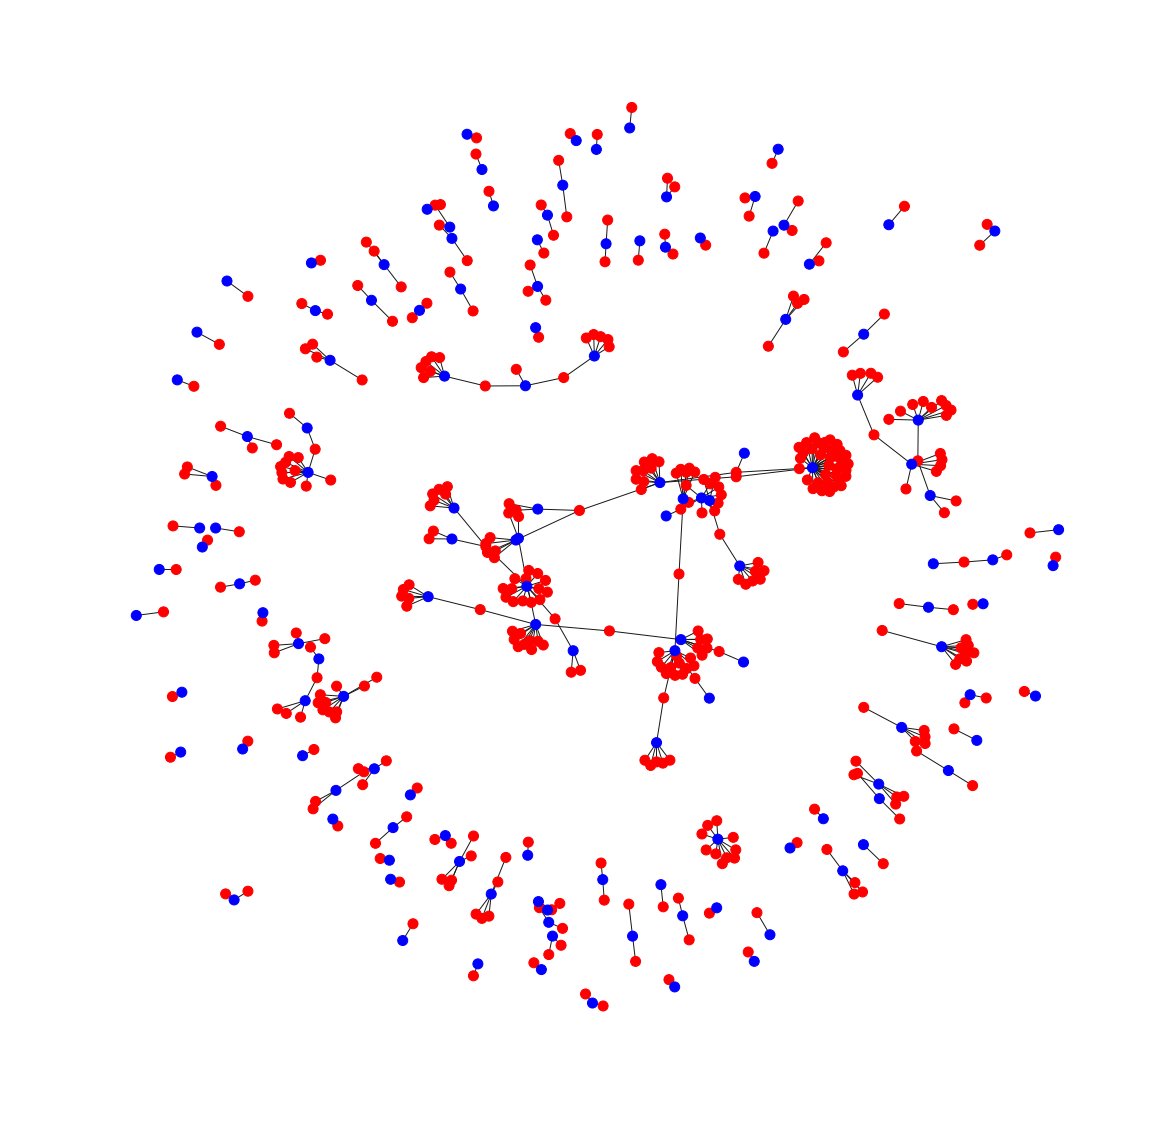

In [26]:
# nodes
reviewer_nodes = subset.reviewer_id.unique().tolist()
host_nodes = subset.host_id.unique().tolist()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,iterations=35)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

### Bipartite host graph

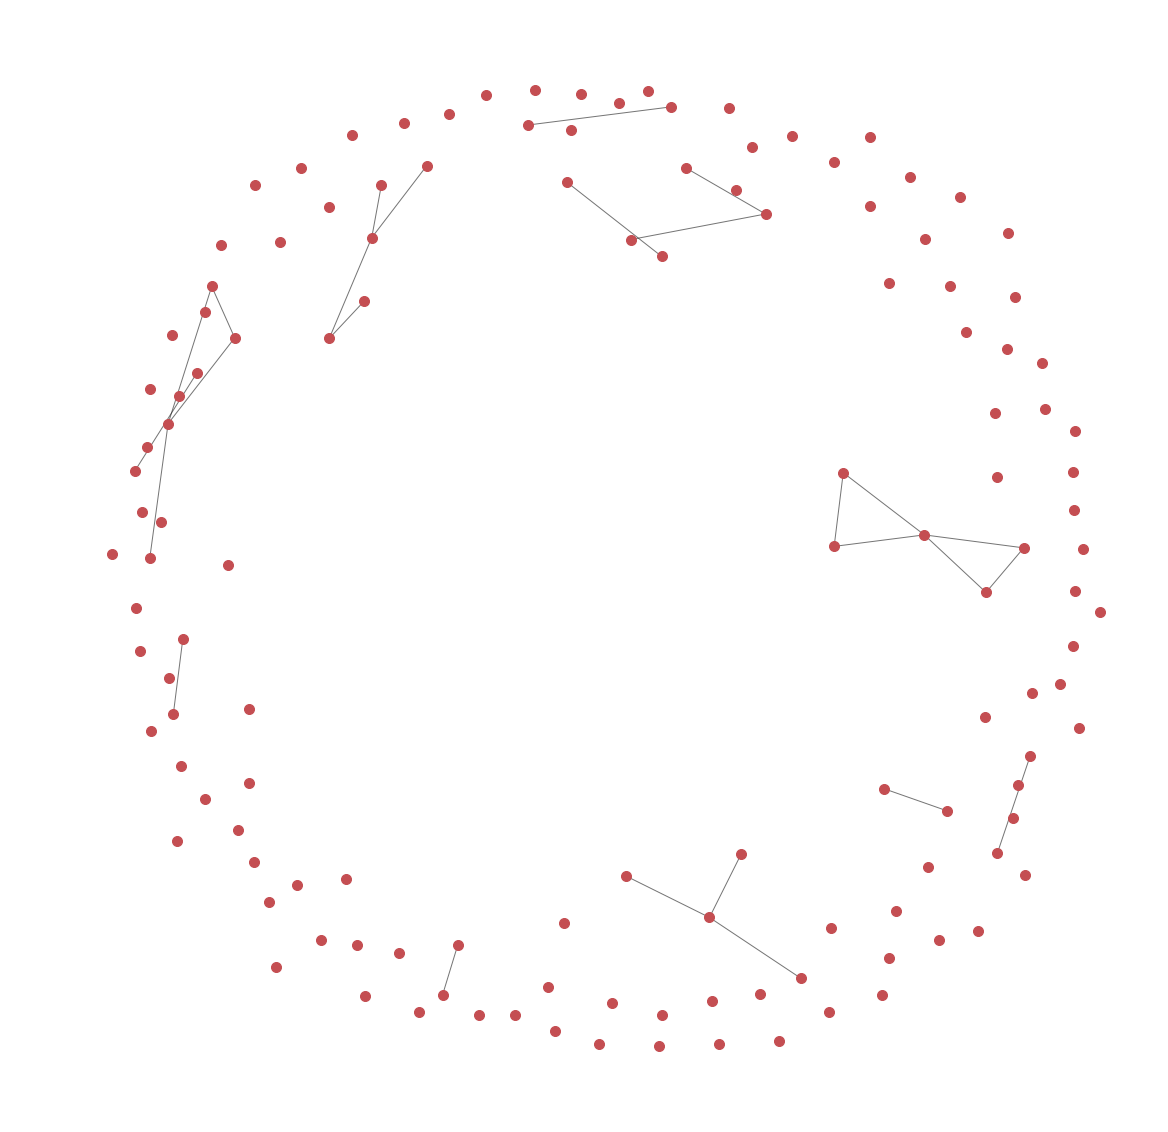

In [27]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique().tolist()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B,iterations=15)
labels = {node: labels_dict[node] for node in B.nodes()}

# create plot
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.6)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [28]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 98


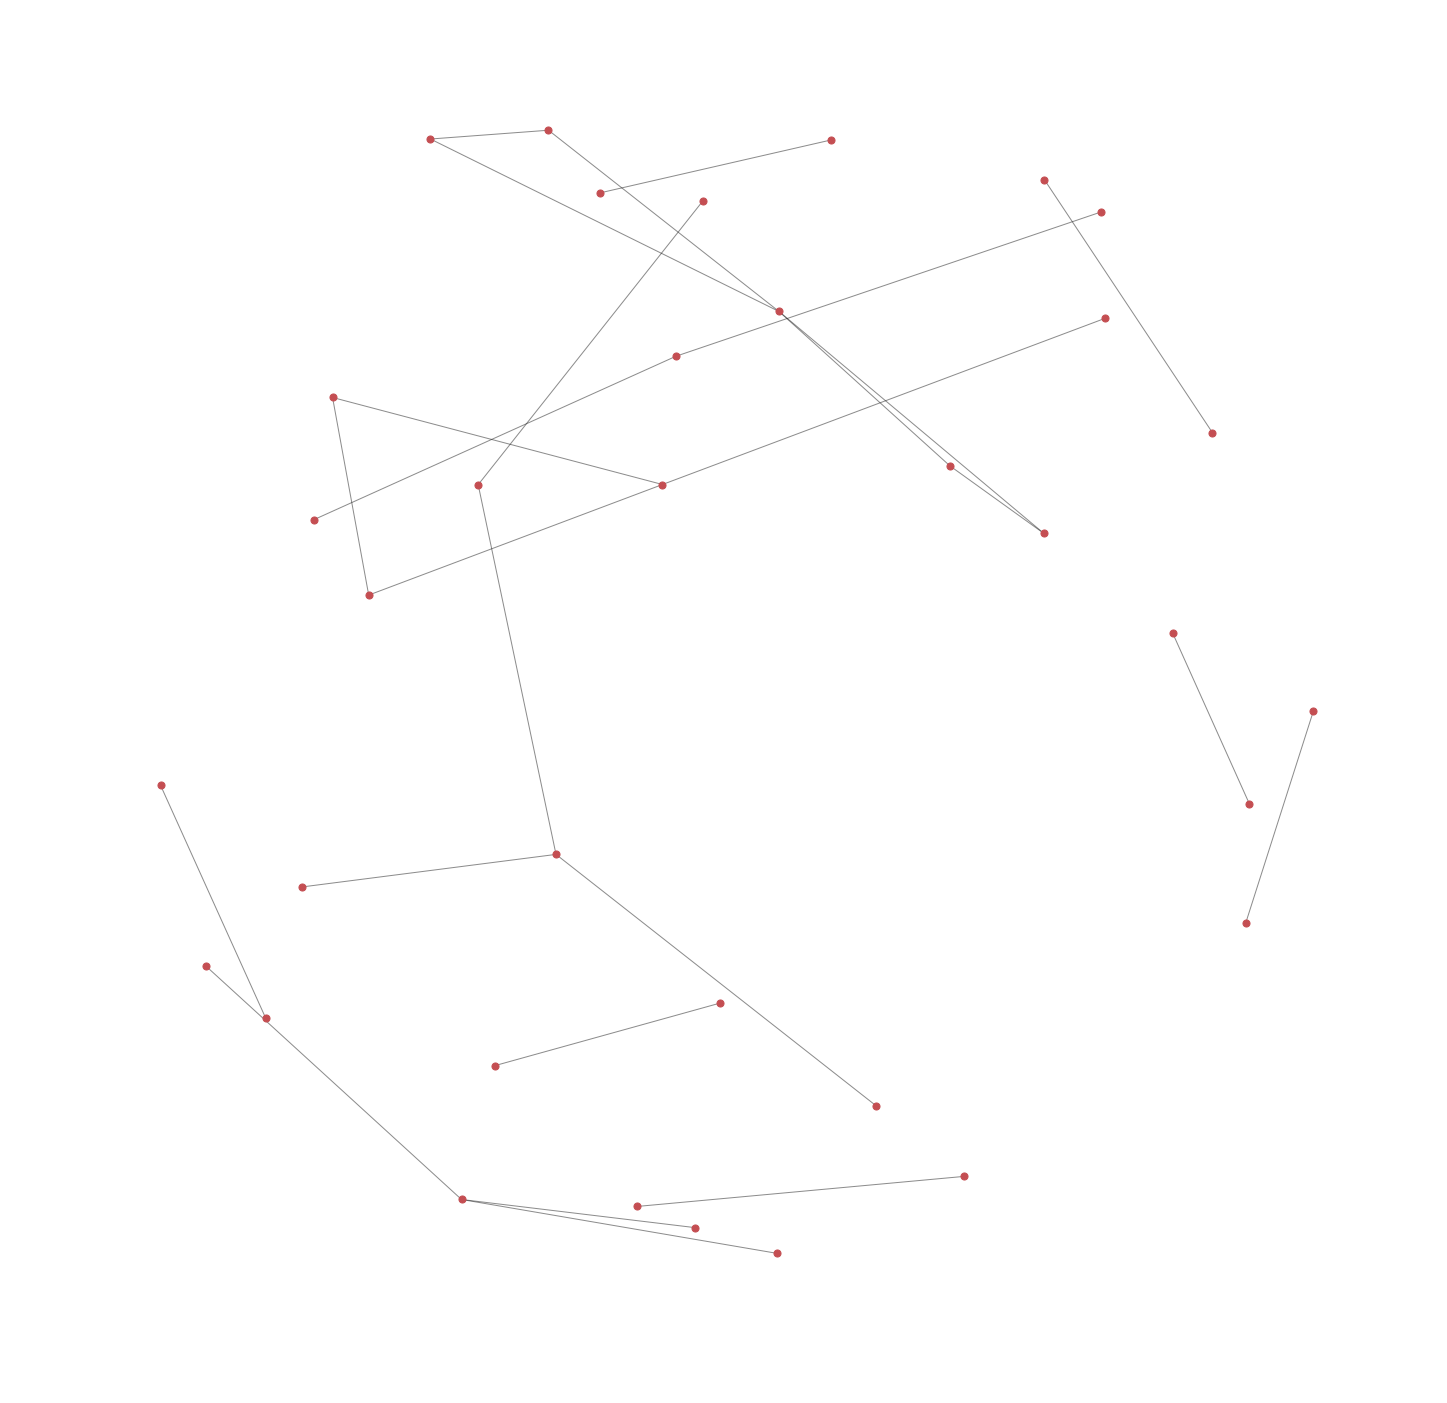

In [29]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B,iterations=16)
labels = {node: labels_dict[node] for node in B.nodes()}

plt.figure(figsize=(25,25))
# nx.draw_networkx(B, pos, with_labels=False, node_size=100)
nx.draw_networkx_nodes(B, pos, node_size=50)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.5)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()